# Project: Twitter Vaccine Sentiment Analysis  : 
 ### <b><u>Aim</u> :
 - Finding out the sentiment related to vaccine tweets from twitter
 - Finding out the sentiment related to vaccine tweets from twitter based on top 3 locations
 - Performing Topic Modeling and Topic coherence to find out the Topics related to the above tweets
 

# Importing necessary libraries

In [1]:
import numpy as np 
import pandas as pd 
import re
import string
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import random
import json
import warnings

from numpy import array
from PIL import Image
from collections import Counter
from wordcloud import WordCloud,STOPWORDS
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from nltk.util import ngrams
from nltk.sentiment.vader import SentimentIntensityAnalyzer as Vader
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from textblob import TextBlob

import plotly
import plotly.offline as pyoff
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot, plot
import plotly.graph_objs as go
import logging
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


warnings.filterwarnings('ignore')
from gensim.models.coherencemodel import CoherenceModel
from gensim.models import Phrases
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary

plt.rc('figure',figsize=(17,13))
sns.set_style('whitegrid')
pyLDAvis.enable_notebook()

In [2]:
#Helper functions

#Removes duplicate words
def dup(top_words):
    a=[]
    unq = []
    for i in top_words:
        a.append(i.split(' '))
    for l in a:
        for element in l:
            unq.append(element)
    return unq

#Creating a word cloud
def wcloud(my_list,rs):
    word_cloud_dict=Counter(my_list)
    wordcloud_T = WordCloud(width = 600, height = 400,max_words=500,max_font_size=500,collocations = False,random_state=rs,colormap = 'nipy_spectral', background_color='white',mask=mask).generate_from_frequencies(word_cloud_dict)

    plt.figure(figsize=(11,8))
    plt.imshow(wordcloud_T)
    plt.title('Top 3 words in Topic Model',fontsize=16,fontweight='bold')
    plt.axis("off")
    return plt.show()

#Plotting Sentiments based on Country location
def country_name(country):
    plt.subplot(2,1,2)
    plt.title('Distributions of Sentiments based on location',fontsize=19,fontweight='bold')
    sns.kdeplot(country['Negative Sentiment'],cumulative=True, color = 'red')
    sns.kdeplot(country['Positive Sentiment'],cumulative=True, color = 'green')
    sns.kdeplot(country['Neutral Sentiment'],cumulative=True, color = 'black')
    plt.xlabel('Sentiment Value',fontsize=12)
    return plt.show()

#Creating top n number of words per Topic
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

#Computing Coherence Value
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
   
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

#Prepossing the text
def docs_preprocessor(docs):
    tokenizer = RegexpTokenizer(r'\w+')
    for idx in range(len(docs)):
        docs[idx] = docs[idx].lower()  # Convert to lowercase.
        docs[idx] = tokenizer.tokenize(docs[idx])  # Split into words.

    # Remove numbers, but not words that contain numbers.
    docs = [[token for token in doc if not token.isdigit()] for doc in docs]
    
    # Remove words that are only one character.
    docs = [[token for token in doc if len(token) > 3] for doc in docs]
    
    # Lemmatize all words in documents.
    lemmatizer = WordNetLemmatizer()
    docs = [[lemmatizer.lemmatize(token) for token in doc] for doc in docs]
  
    return docs

#Creating Topic matrix
def get_keys(topic_matrix):
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

#Creating word counts
def keys_to_counts(keys):
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)


# Importing file

In [3]:
data = pd.read_csv('vaccination_tweets.csv')
data.text =data.text.str.lower()
data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folks said daikon paste could treat a cyt...,['PfizerBioNTech'],Twitter for Android,0,0,False
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,while the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,#coronavirus #sputnikv #astrazeneca #pfizerbio...,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,"facts are immutable, senator, even when you're...",NaN,Twitter Web App,446,2129,False
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,explain to me again why we need a vaccine @bor...,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False


## Cleaning the data

In [4]:
#Removing twitter handlers
data.text = data.text.apply(lambda x:re.sub('@[^\s]+','',x))

#Removing hashtags
data.text = data.text.apply(lambda x:re.sub(r'\B#\S+','',x))

#Removing URLS
data.text = data.text.apply(lambda x:re.sub(r"http\S+", "", x))

#Removing special characters
data.text = data.text.apply(lambda x:' '.join(re.findall(r'\w+', x)))

#Removing all single characters
data.text = data.text.apply(lambda x:re.sub(r'\s+[a-zA-Z]\s+', '', x))

#Substituting multiple spaces with single space
data.text = data.text.apply(lambda x:re.sub(r'\s+', ' ', x, flags=re.I))

In [5]:
#Using SentimentIntensityAnalyzer to calculate the sentiments
vader = Vader()

#getting the polarity scores
data['sentiments'] = data['text'].apply(lambda x: vader.polarity_scores(' '.join(re.findall(r'\w+',x.lower()))))

#Feature Engineering
data['Positive Sentiment'] = data['sentiments'].apply(lambda x: x['pos']+1*(10**-6)) 
data['Neutral Sentiment']= data['sentiments'].apply(lambda x: x['neu']+1*(10**-6))
data['Negative Sentiment'] = data['sentiments'].apply(lambda x: x['neg']+1*(10**-6))

data.head()

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,sentiments,Positive Sentiment,Neutral Sentiment,Negative Sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folks said daikon paste could treatcytoki...,['PfizerBioNTech'],Twitter for Android,0,0,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000001,1.000001,0.000001
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,while the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,"{'neg': 0.125, 'neu': 0.766, 'pos': 0.109, 'co...",0.109001,0.766001,0.125001
2,1337858199140118533,eli🇱🇹🇪🇺👌,Your Bed,"heil, hydra 🖐☺",2020-06-25 23:30:28,10,88,155,False,2020-12-12 20:33:45,russian vaccine is created to last 2 4 years,"['coronavirus', 'SputnikV', 'AstraZeneca', 'Pf...",Twitter for Android,0,0,False,"{'neg': 0.0, 'neu': 0.75, 'pos': 0.25, 'compou...",0.250001,0.750001,0.000001
3,1337855739918835717,Charles Adler,"Vancouver, BC - Canada","Hosting ""CharlesAdlerTonight"" Global News Radi...",2008-09-10 11:28:53,49165,3933,21853,True,2020-12-12 20:23:59,facts are immutable senator even when you re n...,NaN,Twitter Web App,446,2129,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000001,1.000001,0.000001
4,1337854064604966912,Citizen News Channel,NaN,Citizen News Channel bringing you an alternati...,2020-04-23 17:58:42,152,580,1473,False,2020-12-12 20:17:19,explain to me again why we needvaccine,"['whereareallthesickpeople', 'PfizerBioNTech']",Twitter for iPhone,0,0,False,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000001,1.000001,0.000001


In [6]:
data.drop(columns=['sentiments'],inplace=True)

In [7]:
data.head(2)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Positive Sentiment,Neutral Sentiment,Negative Sentiment
0,1340539111971516416,Rachel Roh,"La Crescenta-Montrose, CA",Aggregator of Asian American news; scanning di...,2009-04-08 17:52:46,405,1692,3247,False,2020-12-20 06:06:44,same folks said daikon paste could treatcytoki...,['PfizerBioNTech'],Twitter for Android,0,0,False,0.000001,1.000001,0.000001
1,1338158543359250433,Albert Fong,"San Francisco, CA","Marketing dude, tech geek, heavy metal & '80s ...",2009-09-21 15:27:30,834,666,178,False,2020-12-13 16:27:13,while the world has been on the wrong side of ...,NaN,Twitter Web App,1,1,False,0.109001,0.766001,0.125001


In [8]:
#Dimensions of the data
data.shape

(11020, 19)

# Exploratory Data Analysis
- Using a kernel density estimate (KDE) plot for visualizing the distribution of Sentiments in the dataset

### Finding the Sentiments based on top 3 locations of the tweets

In [9]:
data_loc =data[(data['user_location'] == 'India') | (data['user_location'] == 'Malaysia') | (data['user_location'] == 'London')  ]

In [10]:
data_loc.head(2)

,id,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,retweets,favorites,is_retweet,Positive Sentiment,Neutral Sentiment,Negative Sentiment
12,1337815730486702087,WION,India,#WION: World Is One | Welcome to India’s first...,2016-03-21 03:44:54,292510,91,7531,True,2020-12-12 17:45:00,the agency also released new information for h...,NaN,TweetDeck,0,18,False,0.151001,0.849001,0.000001
30,1337760271151063040,Andy Thomas,London,Retweets not necessarily endorsements.,2009-03-07 20:39:15,1151,4301,95963,False,2020-12-12 14:04:37,6 deaths so far itonly death nothing to worry ...,"['CovidVaccines', 'Pfizervaccine']",Twitter for Android,0,2,False,0.165001,0.549001,0.286001


In [11]:
data_loc_sen = data_loc[['user_location','Positive Sentiment','Negative Sentiment','Neutral Sentiment']]

In [12]:
data_loc_sen

,user_location,Positive Sentiment,Negative Sentiment,Neutral Sentiment
12,India,0.151001,0.000001,0.849001
30,London,0.165001,0.286001,0.549001
75,India,0.000001,0.000001,1.000001
90,London,0.489001,0.000001,0.511001
94,India,0.000001,0.000001,1.000001
...,...,...,...,...
10805,Malaysia,0.000001,0.000001,1.000001
10889,Malaysia,0.366001,0.000001,0.634001
10913,Malaysia,0.000001,0.000001,1.000001
10986,Malaysia,0.000001,0.000001,1.000001


In [13]:
df_india = data_loc_sen[(data_loc_sen['user_location'] == 'India')]
df_mal = data_loc_sen[(data_loc_sen['user_location'] == 'Malaysia')]
df_lon = data_loc_sen[(data_loc_sen['user_location'] == 'London')]

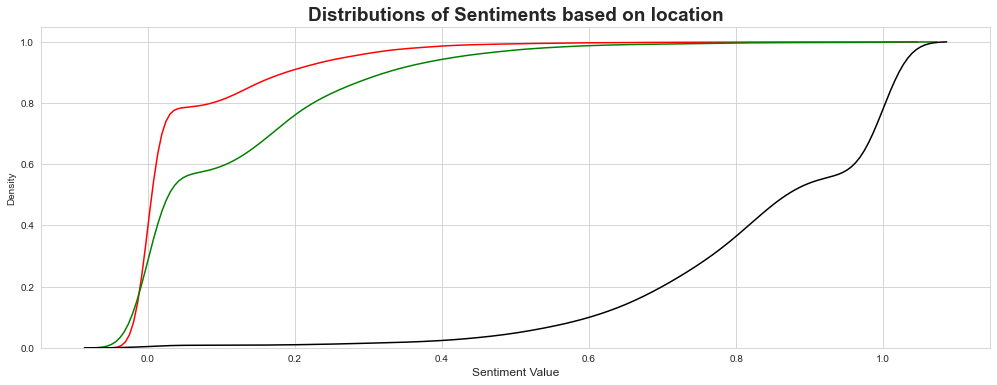

In [14]:
#Plotting overall sentiment distribution of all the sentiments
country_name(data)

- for the above distribuiton we can say that positive sentiments and negative sentiments are almost same but neutral sentiment give an off distribution

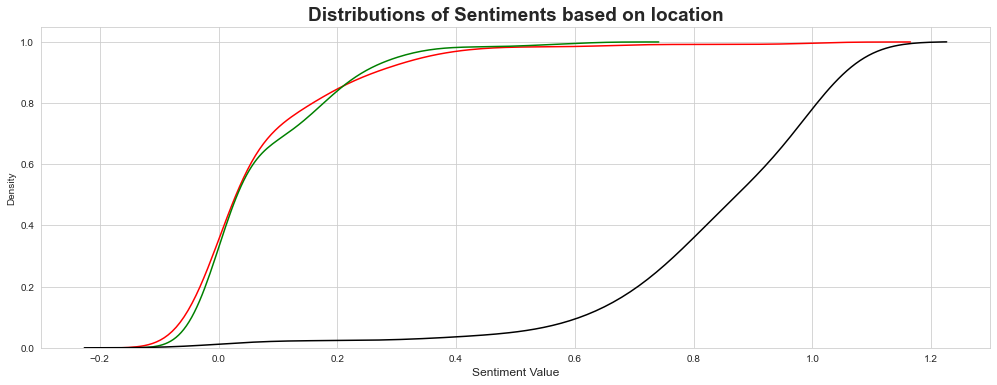

In [15]:
#Plotting overall sentiment distribution based on location 'India'
country_name(df_india)

- For the above distribution we can say that sentiment distributions across India are less positive and more negative

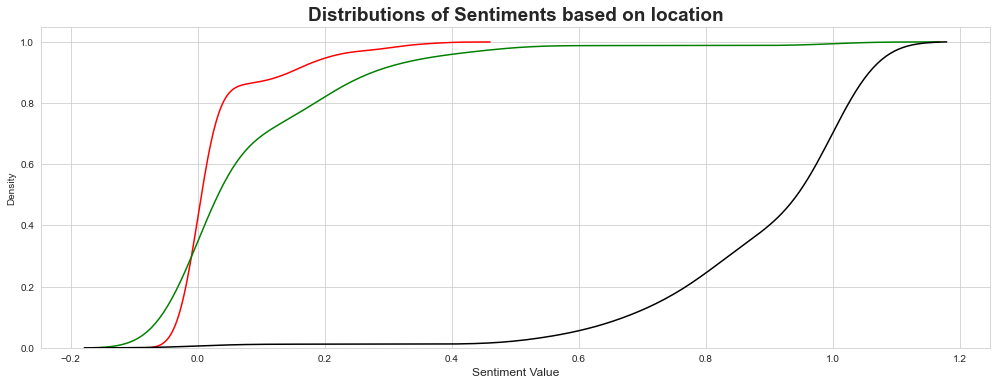

In [16]:
#Plotting overall sentiment distribution based on location 'Malaysia'
country_name(df_mal)

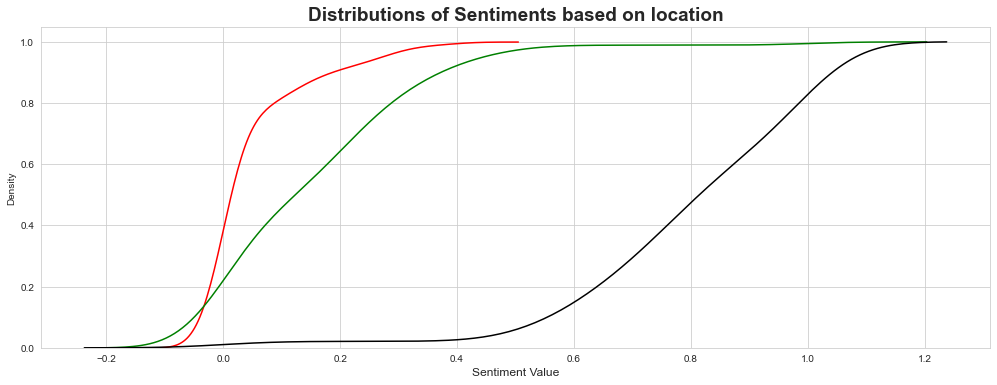

In [17]:
#Plotting overall sentiment distribution based on location 'London'
country_name(df_lon)

- For the above distribution we can say that sentiment distributions across London are very positive and less negative

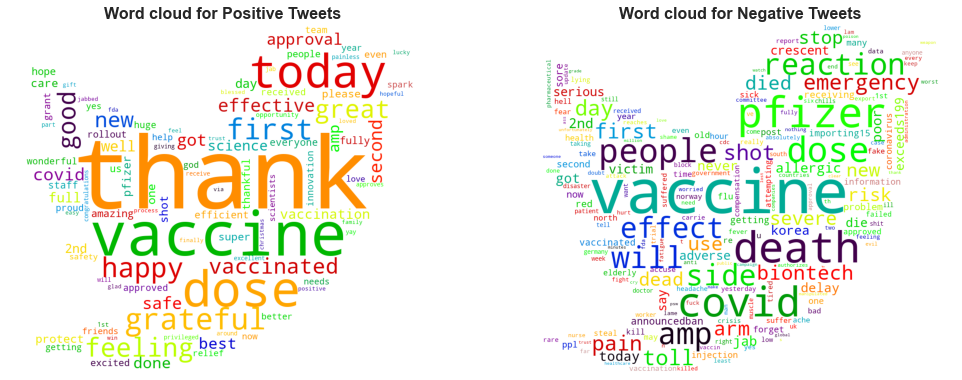

In [18]:
#Building wordcloud for positive and negative words
Most_Positive = data[data['Positive Sentiment'].between(0.4,1)]
Most_Negative = data[data['Negative Sentiment'].between(0.25,1)]

Most_Positive_text = ' '.join(Most_Positive.text)
Most_Negative_text = ' '.join(Most_Negative.text)

#Creating a twitter shaped word cloud
mask = np.array(Image.open('twitter.png'))

pwc = WordCloud(width=600,height=400,max_font_size=500,max_words=100,random_state=1,colormap = 'nipy_spectral',collocations = False, background_color='white', mask = mask).generate(Most_Positive_text)
nwc = WordCloud(width=600,height=400,collocations = False,random_state=1,colormap = 'nipy_spectral', background_color='white',mask=mask,).generate(Most_Negative_text)

plt.subplot(1,2,1)
plt.title('Word cloud for Positive Tweets',fontsize=16,fontweight='bold')
plt.imshow(pwc)
plt.axis('off')
plt.subplot(1,2,2)
plt.title('Word cloud for Negative Tweets',fontsize=16,fontweight='bold')
plt.imshow(nwc)
plt.axis('off')

plt.show()

### Finding out 50 words in most Positive and Negative tweets

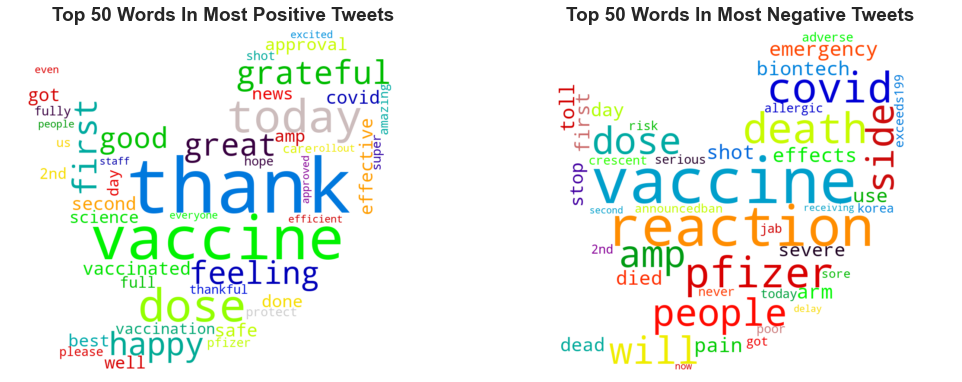

In [19]:
l_t = Most_Positive_text

w1_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w1_dict[w] = w1_dict.get(w,0)+1
w1_dict = {k: v for k, v in sorted(w1_dict.items(), key=lambda item: item[1],reverse=True)}

l_t = Most_Negative_text
w2_dict = dict()
for word in l_t.split():
    w= word.strip()
    if w in STOPWORDS:
        continue
    else:
        w2_dict[w] = w2_dict.get(w,0)+1
w2_dict = {k: v for k, v in sorted(w2_dict.items(), key=lambda item: item[1],reverse=True)}

top_10_pos = list(w1_dict.keys())[:50]
top_10_neg = list(w2_dict.keys())[:50]


#Creating word cloud
plt.subplot(1,2,1)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral',random_state=2,background_color="white",mask =mask).generate(' '.join(top_10_pos))
plt.title('Top 50 Words In Most Positive Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c, interpolation="bilinear")
plt.axis('off')
plt.subplot(1,2,2)
w_c = WordCloud(width=600,height=400,collocations = False,colormap='nipy_spectral',random_state=6,background_color="white", mask = mask).generate(' '.join(top_10_neg))
plt.title('Top 50 Words In Most Negative Tweets',fontsize=19,fontweight='bold')
plt.imshow(w_c, interpolation="bilinear")
plt.axis('off')
plt.show()

In [20]:
#Creating a new dataframe for Topic Modeling
df = data
df_t =  df[['date','text']]
reindexed_data = df_t['text']
reindexed_data.index = df_t['date']
df_t.head()

,date,text
0,2020-12-20 06:06:44,same folks said daikon paste could treatcytoki...
1,2020-12-13 16:27:13,while the world has been on the wrong side of ...
2,2020-12-12 20:33:45,russian vaccine is created to last 2 4 years
3,2020-12-12 20:23:59,facts are immutable senator even when you re n...
4,2020-12-12 20:17:19,explain to me again why we needvaccine


In [21]:
#Coverting the document to array
docs =array(df_t['text'])

#Uding our preprocessing helper function on our document
docs = docs_preprocessor(docs)

#Create Biagram & Trigram Models 

bigram = Phrases(docs, min_count=10)
trigram = Phrases(bigram[docs])

for idx in range(len(docs)):
    for token in bigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
    for token in trigram[docs[idx]]:
        if '_' in token:
            # Token is a bigram, add to document.
            docs[idx].append(token)
            
# Create a dictionary representation of the documents.
dictionary = Dictionary(docs)
dictionary.filter_extremes(no_below=10, no_above=0.2)

#Create dictionary and corpus required for Topic Modeling
corpus = [dictionary.doc2bow(doc) for doc in docs]
print('Number of unique tokens: %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))
print(corpus[:1])

Number of unique tokens: 1286
Number of documents: 11020
[[(0, 1), (1, 1), (2, 1), (3, 1)]]


In [22]:
#Picking 15 topics 
num_topics = 15

# Making an index to word dictionary
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

#Running LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=500 , \
                       alpha='auto', eta='auto', \
                       iterations=400, num_topics=num_topics, \
                       passes=20 , eval_every= 1)
# Print the Keyword in the 5 topics
print(lda_model.print_topics())

[(0, '0.135*"when" + 0.103*"will" + 0.084*"dos" + 0.076*"year" + 0.061*"last_week" + 0.053*"last" + 0.049*"they" + 0.036*"receive" + 0.024*"week" + 0.023*"year_old"'), (1, '0.221*"side_effect" + 0.094*"been" + 0.088*"effect" + 0.085*"side" + 0.080*"have_been" + 0.063*"most" + 0.036*"read" + 0.032*"read_more" + 0.020*"best" + 0.019*"taking"'), (2, '0.143*"shot" + 0.124*"case" + 0.107*"observe" + 0.088*"booster" + 0.083*"after" + 0.068*"booster_shot" + 0.054*"were" + 0.028*"infection" + 0.025*"getting" + 0.022*"until"'), (3, '0.202*"pfizer_biontech" + 0.197*"pfizer" + 0.076*"biontech" + 0.044*"covid" + 0.038*"study" + 0.036*"effective" + 0.028*"million_dos" + 0.025*"astrazeneca" + 0.023*"million" + 0.021*"variant"'), (4, '0.144*"from" + 0.121*"child" + 0.082*"child_aged" + 0.076*"aged" + 0.057*"full_approval" + 0.048*"full" + 0.026*"like" + 0.025*"good" + 0.023*"news" + 0.022*"some"'), (5, '0.220*"this" + 0.137*"number" + 0.065*"approval" + 0.050*"what" + 0.050*"about" + 0.038*"only" + 0

In [23]:
# Computing Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.4551841148442295


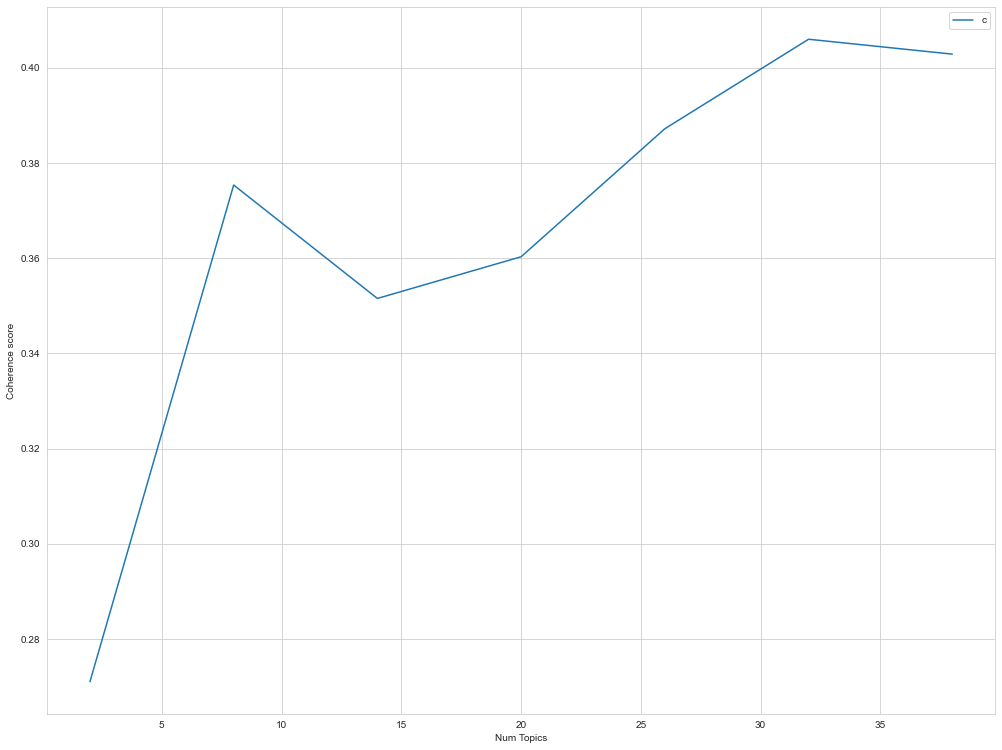

In [24]:
# Finding out the best k value
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=docs, start=2, limit=40, step=6)
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Accoding to the graph the best k value is 32

In [34]:
#Calculating coherence score for 32 topics 
num_topics = 32

# Making an index to word dictionary
temp = dictionary[0]  # only to "load" the dictionary.
id2word = dictionary.id2token

#Running LDA model
lda_model = LdaModel(corpus=corpus, id2word=id2word, chunksize=500 , \
                       alpha='auto', eta='auto', \
                       iterations=400, num_topics=num_topics, \
                       passes=20 , eval_every= 1)

# Computing Coherence Score using c_v
coherence_model_lda = CoherenceModel(model=lda_model, texts=docs, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Coherence Score:  0.5551039436825008


In [35]:
#Vectorizing the text
# small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000 )
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000, max_df = 300 )
small_text_sample = reindexed_data.sample(n=10000, random_state=0, replace= True).values

print('Text before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Text after vectorization: \n{}'.format(small_document_term_matrix[123]))

Text before vectorization: got my today seen by passionate and excellent staff thank you
Text after vectorization: 
  (0, 3254)	1
  (0, 7797)	1
  (0, 6564)	1
  (0, 8234)	1


In [38]:
# Choosing number of Topics according to the K value from coherence graph
n_topics = 32

In [39]:
# Fitting LDA model
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [40]:
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [41]:
#Extracting top 10 words from eahch topic 

top_n_words_lda = get_top_n_words(5, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])
    

Topic 1:  need questions pandemic follow open
Topic 2:  phase shipment making individual results
Topic 3:  deaths 23 norway says cases
Topic 4:  fully weeks ceo available vaxxed
Topic 5:  staff morning used technology offered
Topic 6:  arm day hours post sore
Topic 7:  arrive lakh gifted 30th consignment
Topic 8:  000 like 300 announcedban crescent
Topic 9:  approved know fda use coronavirus
Topic 10:  approval emergency use fda read
Topic 11:  effects world given real yesterday
Topic 12:  thanks jab science does scientists
Topic 13:  new getting variant think country
Topic 14:  safe trial possible stay effective
Topic 15:  1st injection site 2021 jab
Topic 16:  good news agreement mum th
Topic 17:  days protection risk ready infection
Topic 18:  health minister reaction allergic severe
Topic 19:  grateful better ppl feeling friday
Topic 20:  uk healthcare workers drug food
Topic 21:  booster centre group age purchase
Topic 22:  work president biden complete covid19
Topic 23:  study da

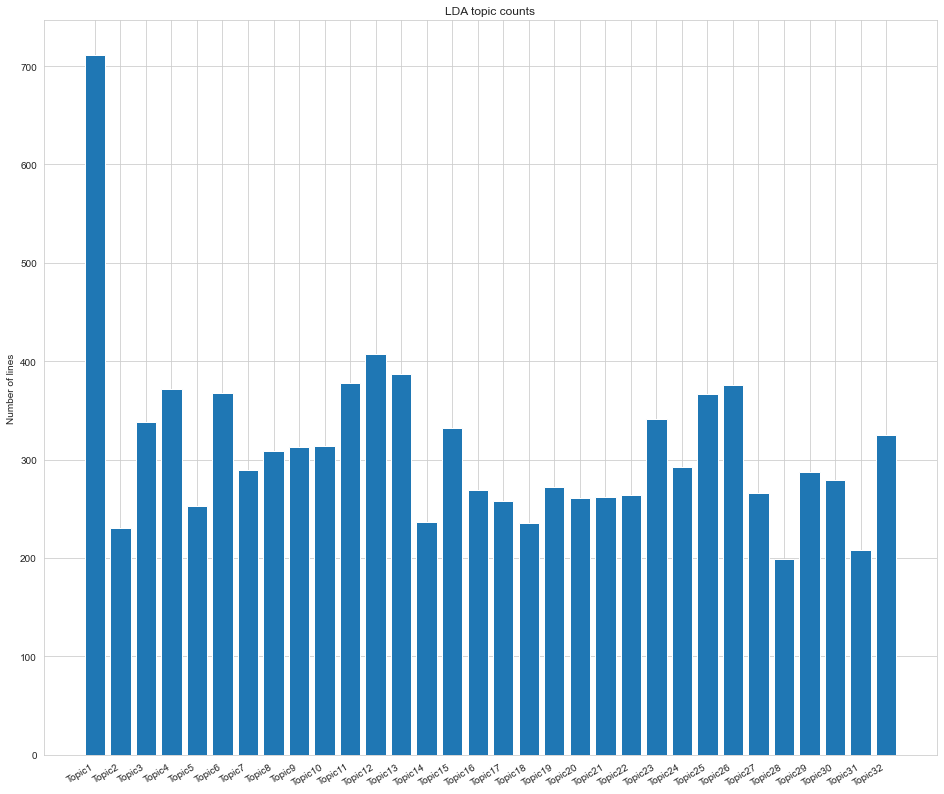

In [42]:
#Extracting Top 3 words
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic{}'.format(i+1) for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,15))
fig.autofmt_xdate()
ax.bar(lda_categories, lda_counts)
ax.set_xticks(lda_categories)
ax.set_xticklabels(labels)
ax.set_title('LDA topic counts')
ax.set_ylabel('Number of lines')
plt.show()

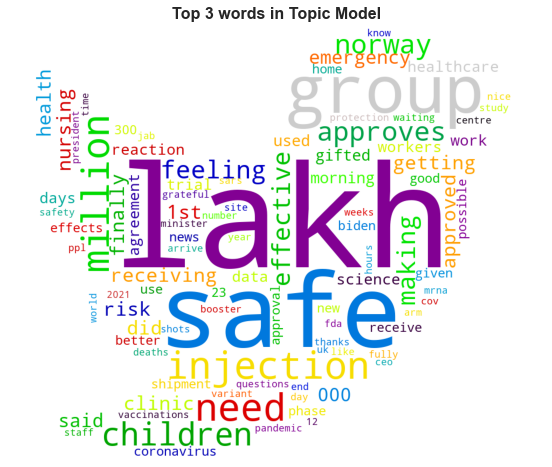

In [43]:
#Removing duplicate words
unq = dup(top_3_words)
words = set(unq )       
        
#Creating a Word cloud for top 3 words from each topic
wcloud(words,2)